In [1]:
!nvidia-smi

Tue Jan 21 19:54:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20Xm         On   | 00000000:08:00.0 Off |                    0 |
| N/A   49C    P0    57W / 235W |      0MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20Xm         On   | 00000000:84:00.0 Off |                    0 |
| N/A   32C    P8    18W / 235W |      0MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
go = False
if go:
    
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
    import tensorflow as tf
    from keras import backend as K

    set_gpu=True

    if set_gpu:
        os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
        os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
        print(os.environ["CUDA_VISIBLE_DEVICES"])


        num_cores = 39

        GPU=True
        CPU=False

        if GPU:
            num_GPU = 1
            num_CPU = 1
        if CPU:
            num_CPU = 1
            num_GPU = 0

        config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                inter_op_parallelism_threads=num_cores, 
                                allow_soft_placement=True,
                                device_count = {'CPU' : num_CPU,
                                                'GPU' : num_GPU}
                               )

        session = tf.Session(config=config)
        K.set_session(session)


In [3]:
#!wget https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv

In [7]:
#!pip install pyforest
#from pyforest import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras


df = pd.read_csv("../data/df_final_processed.csv", index_col = 0)
df.head()

,datetime,level,rain,vel_wind,dir_wind,level_std,level_scaled,dist,dist_std,dist_scaled,ts,inv_dist,inv_dist_std,inv_dist_scaled,inv_dist_2,inv_dist_2_std,inv_dist_2_scaled,dummy_rain,vel_wind_kmh,vel_wind_dummy
0,2010-01-01 00:00:00,102.0,0.0,0.2,337.5,2.461852,0.763636,353510.208614,-2.034933,0.043682,1262304000000000000,0.000003,2.156252,0.949046,8.001955e-12,2.219529,0.945147,0,0.72,0
1,2010-01-01 01:00:00,100.0,0.0,0.7,315.0,2.389875,0.754545,353731.458075,-2.020637,0.047277,1262307600000000000,0.000003,2.139458,0.944887,7.991948e-12,2.201361,0.940688,0,2.52,0
2,2010-01-01 02:00:00,86.0,0.0,1.5,247.5,1.886035,0.690909,354197.433405,-1.990529,0.054849,1262311200000000000,0.000003,2.104155,0.936144,7.970933e-12,2.163208,0.931324,0,5.40,0
3,2010-01-01 03:00:00,74.0,0.0,1.3,247.5,1.454172,0.636364,354875.253700,-1.946732,0.065863,1262314800000000000,0.000003,2.052969,0.923467,7.940513e-12,2.107977,0.917768,0,4.68,0
4,2010-01-01 04:00:00,65.0,0.0,1.3,247.5,1.130275,0.595455,355718.662776,-1.892236,0.079569,1262318400000000000,0.000003,1.989551,0.907761,7.902904e-12,2.039695,0.901010,0,4.68,0


In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

#some zeroes
#series = df.level_scaled.values
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0.01, 1))

series = sc.fit_transform(df.level.values.reshape(-1, 1))

split_index = -7*24

#test_series = series [split_index:]
#series = series [:split_index]
n_features = 1
#series = series.reshape((len(series), n_features))
#test_series = test_series.reshape((len(test_series), n_features))

series.shape


(78888, 1)

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, CuDNNLSTM, LeakyReLU
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.optimizers import Adam 


# define model
def make_model(n_input, n_features, 
               verbose = False, multi = True, use_CuDNNLSTM = True,
              loss = "mse", metrics = ["mae", "mape"],
              lr = 0.001):
    K.clear_session()
    LSTM_layer = LSTM if not use_CuDNNLSTM else CuDNNLSTM
    model = Sequential()
    model.add(LSTM_layer(1024, input_shape=(n_input, n_features), return_sequences=True))
    model.add(LeakyReLU())
    model.add(LSTM_layer(512, return_sequences=True))
    model.add(LeakyReLU())
    #model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM_layer(128))
    model.add(LeakyReLU())
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dense(1, activation = "sigmoid") )
    opt = Adam (lr = lr )
    model.compile(optimizer='adam', loss='mse', metrics = ["mae"])
    if verbose:
        model.summary()
    if multi:
        mmodel = multi_gpu_model(model, 2)
        mmodel.compile(optimizer='adam', loss=loss, metrics = metrics)
        return mmodel, model
    else: 
        
        return None, model

In [11]:
# define generator
n_input = 1*24*1
batch_size = 256
train_generator = TimeseriesGenerator(series[:split_index], series[:split_index], length=n_input, batch_size=batch_size)
test_generator = TimeseriesGenerator(series[-n_input + split_index:], series[-n_input + split_index:], length=n_input, batch_size=8)

In [12]:
mmodel, model = make_model(n_input, n_features, lr = 0.01,
                           multi = False, use_CuDNNLSTM = True, verbose = True,
                           loss = "mse", metrics = ["mae", "mape"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 24, 1024)          4206592   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 1024)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 24, 512)           3149824   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 512)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               328704    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
__________

In [13]:
import wandb
wandb.login()


True

In [14]:
from wandb.keras import WandbCallback as wb

In [15]:
wandb.init(project = "venice_is_drowing", name = "lstm_test")
cfg = wandb.config

cfg.gen_batch_size = batch_size
cfg.n_features = n_features
cfg.n_input = n_input
cfg.epochs = 100

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
from keras.callbacks import EarlyStopping
from myutils import TrainingPlot

plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)
# fit model
history = model.fit_generator(
    train_generator,  
    epochs=cfg.epochs,
    #steps_per_epoch=2,
    verbose=1, 
    
    validation_data=test_generator, 
    callbacks=[plot_losses, 
               es, 
               wb(log_gradients=False, log_weights=False)]
)

Epoch 1/100
  1/308 [..............................] - ETA: 58s - loss: 0.0213 - mean_absolute_error: 0.1194

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


BrokenPipeError: [Errno 32] Broken pipe

In [221]:
pred_generator = TimeseriesGenerator(series[-n_input + split_index:], series[-n_input + split_index:], length=n_input, batch_size=1)
mmodel.predict_generator(test_generator, steps=1)[0]

array([0.55324656], dtype=float32)

In [222]:
test_series = series[split_index:]
test_series[0]

array([0.541])

In [224]:
mape = (test_series[0]-mmodel.predict_generator(test_generator, steps=1)[0])/test_series[0]
mape

array([-0.02263689])

[]

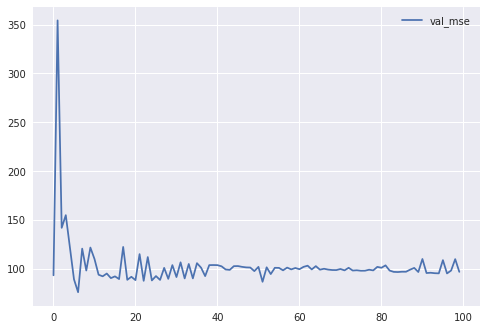

In [109]:
#plt.plot(history1.history["mean_absolute_error"], label = "mae")
#plt.plot(history1.history["mean_absolute_percentage_error"], label = "mape")
#plt.plot(history1.history["val_mean_absolute_error"], label = "val_mae")
plt.plot(history1.history["val_mean_absolute_percentage_error"], label = "val_mse")
#plt.ylim((0,1))
plt.legend()
plt.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

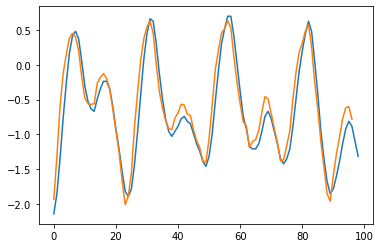

In [0]:
plt.plot(test_series[1:])
plt.plot(model.predict_generator(test_generator)[:-1])

In [0]:
for x, y in test_generator:
  print(x)
  print("#")
  print(y)
  break

[[[-2.21666001]
  [-2.1446829 ]]

 [[-2.1446829 ]
  [-1.85677448]]

 [[-1.85677448]
  [-1.35293474]]

 [[-1.35293474]
  [-0.77711789]]

 [[-0.77711789]
  [-0.27327815]]

 [[-0.27327815]
  [ 0.15858448]]

 [[ 0.15858448]
  [ 0.41050435]]

 [[ 0.41050435]
  [ 0.48248146]]]
#
[[-1.85677448]
 [-1.35293474]
 [-0.77711789]
 [-0.27327815]
 [ 0.15858448]
 [ 0.41050435]
 [ 0.48248146]
 [ 0.3745158 ]]


In [0]:
model.evaluate_generator(test_generator)

[0.022409923222600197, 0.12407879561794047, 0.022409923222600197]